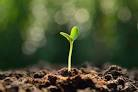

We like to develop a model that is able to classify the correct species given an image with seedlings. Solving this task we would be able to address an important problem of agriculture industries: Plants in the early-growth phase are heavily competing for nutrients and water and often this phase is crucial for a plant to prevail against all other seedlings. Consequently if we would be able to detect wild plants in early phases we could remove them manually which is an advantage for all crop seedlings.

So let's start and see why this dataset is not sufficient to solve this kind of problem! ;-)

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

# About data

**How many images per species are given in the data**

In [2]:
base_path = "../input/v2-plant-seedlings-dataset/nonsegmentedv2/"
#OUTPUT_PATH = "seedlings.pth"
#MODEL_PATH = "../input/seedlingsmodel/seedlings.pth"

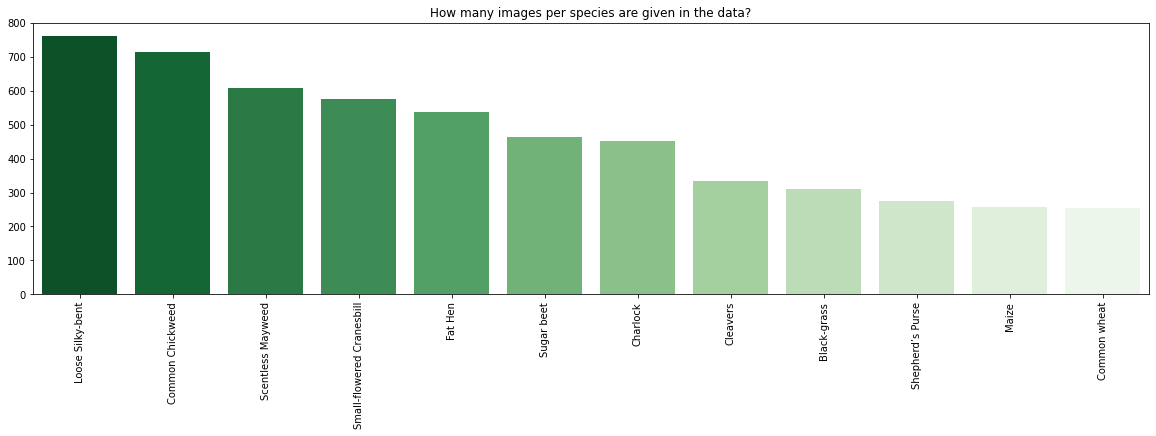

In [3]:
subfolders = listdir(base_path)
names = []
counts = []

for folder in subfolders:
    images = listdir(base_path +folder)
    names.append(folder)
    counts.append(len(images))

counts = np.array(counts)
names = np.array(names)

idx = np.argsort(counts)[::-1]
    
plt.figure(figsize=(20,5))    
sns.barplot(x=names[idx], y=counts[idx], palette="Greens_r")
plt.xticks(rotation=90);
plt.title("How many images per species are given in the data?");

 **Peek at the image files**

In [4]:
image_dir = Path('../input/v2-plant-seedlings-dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

**creating data frame using filepaths and its repective labels**

In [5]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,../input/v2-plant-seedlings-dataset/Common Chi...,Common Chickweed
1,../input/v2-plant-seedlings-dataset/nonsegment...,Scentless Mayweed
2,../input/v2-plant-seedlings-dataset/Small-flow...,Small-flowered Cranesbill


**Display some pictures of the dataset with their labels**

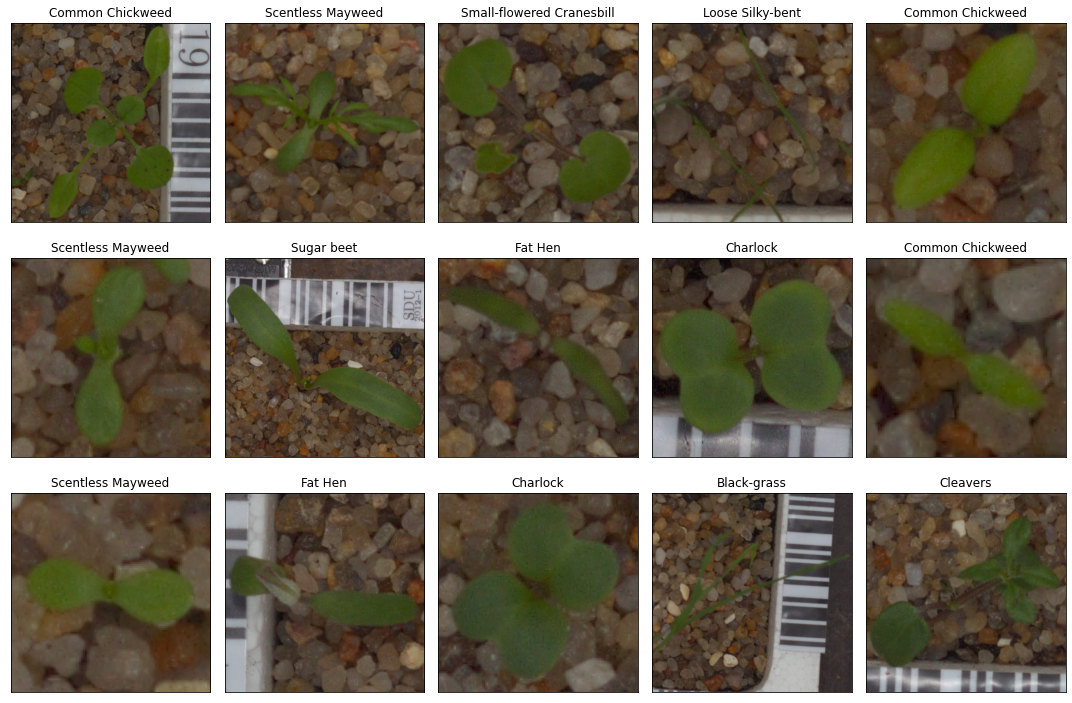

In [6]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

**Load the Images with a generator and Data Augmentation**

1. *what is Data agumentation?*

Data augmentation is a set of techniques to artificially increase the amount of data by generating new data points from existing data. This includes making small changes to data or using deep learning models to generate new data points. 

2. *Why is it important now?*

Machine learning applications especially in the deep learning domain continue to diversify and increase rapidly. Data augmentation techniques may be a good tool against challenges which the artificial intelligence world faces.

Data augmentation is useful to improve performance and outcomes of machine learning models by forming new and different examples to train datasets. If the dataset in a machine learning model is rich and sufficient, the model performs better and more accurately.

For machine learning models, collecting and labeling of data can be exhausting and costly processes. Transformations in datasets by using data augmentation techniques allow companies to reduce these operational costs.

One of the steps into a data model is cleaning data which is necessary for high accuracy models. However, if cleaning reduces the representability of data, then the model cannot provide good predictions for real world inputs. Data augmentation techniques enable machine learning models to be more robust by creating variations that the model may see in the real world.



In [7]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

# Building the Model

**MobileNet**

MobileNets are a class of efficient models for mobile and embedded vision applications. MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural networks.

**MobileNetV2**

The MobileNetV2 architecture is based on an inverted residual structure where the input and output of the residual block are thin bottleneck layers opposite to traditional residual models which use expanded representations in the input an MobileNetV2 uses lightweight depthwise convolutions to filter features in the intermediate expansion layer.



In [8]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

2022-06-15 06:34:16.960451: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


9420800/9406464 [==============================] - 0s 0us/step


In [9]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

# Create the generators
train_generator,test_generator,train_images,val_images,test_images = create_gen()

Found 8973 validated image filenames belonging to 12 classes.
Found 997 validated image filenames belonging to 12 classes.
Found 1108 validated image filenames belonging to 12 classes.


**Separate in train and test data and Create the generators**

**activation = 'relu'**
The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.

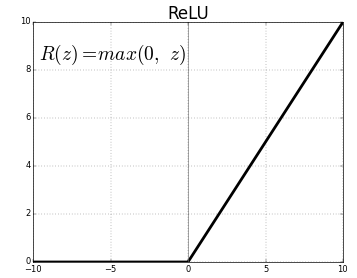

In [10]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

2022-06-15 06:34:24.212029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
281/281 [==============================] - 220s 772ms/step - loss: 0.7916 - accuracy: 0.7287 - val_loss: 0.4911 - val_accuracy: 0.8335
Epoch 2/20
281/281 [==============================] - 181s 643ms/step - loss: 0.3527 - accuracy: 0.8737 - val_loss: 0.3009 - val_accuracy: 0.9037
Epoch 3/20
281/281 [==============================] - 171s 606ms/step - loss: 0.2348 - accuracy: 0.9174 - val_loss: 0.2327 - val_accuracy: 0.9168
Epoch 4/20
281/281 [==============================] - 174s 617ms/step - loss: 0.1689 - accuracy: 0.9405 - val_loss: 0.2554 - val_accuracy: 0.9137
Epoch 5/20
281/281 [==============================] - 182s 645ms/step - loss: 0.1139 - accuracy: 0.9634 - val_loss: 0.3210 - val_accuracy: 0.8947


In [11]:
results = model.evaluate(test_images, verbose=0)

In [12]:
results

[0.23187699913978577, 0.9205776453018188]

# Accuracy on the test set

In [13]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.23188

## Accuracy on the test set: 92.06%

In [14]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Fat Hen', 'Common Chickweed', 'Fat Hen', 'Maize', 'Common wheat']


# Display the result

In [15]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Fat Hen', 'Common Chickweed', 'Fat Hen', 'Maize', 'Common wheat']


In [16]:
model.save("./MODEL2.hdf5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# classification_report

A classification report is a performance evaluation metric in machine learning. It is used to show the precision, recall, F1 Score, and support of your trained classification model.

**precision** :- Precision is defined as the ratio of true positives to the sum of true and false positives.

**Recall** :- Recall is defined as the ratio of true positives to the sum of true positives and false negatives.

**F1 score** :- The F1 is the weighted harmonic mean of precision and recall. The closer the value of the F1 score is to 1.0, the better the expected performance of the model is.

**Support** :- Support is the number of actual occurrences of the class in the dataset. It doesn’t vary between models, it just diagnoses the performance evaluation process.

In [17]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                           precision    recall  f1-score   support

              Black-grass       0.89      0.56      0.69        61
                 Charlock       0.98      1.00      0.99        83
                 Cleavers       0.99      0.97      0.98        69
         Common Chickweed       0.98      0.91      0.94       150
             Common wheat       0.92      0.96      0.94        46
                  Fat Hen       0.85      0.98      0.91       112
         Loose Silky-bent       0.87      0.93      0.90       152
                    Maize       0.95      0.91      0.93        67
        Scentless Mayweed       0.83      0.92      0.87       110
         Shepherd’s Purse       0.91      0.88      0.89        48
Small-flowered Cranesbill       1.00      0.98      0.99       114
               Sugar beet       0.95      0.92      0.93        96

                 accuracy                           0.92      1108
                macro avg       0.93      0.91      0.91    

# confusion_matrix
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

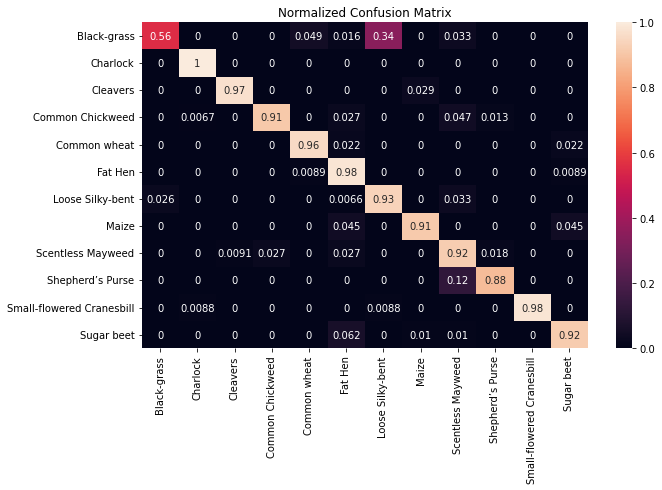

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()